# Experimental Results

In [14]:
# Import libraries.
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Set font properties.
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

# General plotting.
palette = matplotlib.colormaps.get_cmap("tab20")(np.linspace(0, 1, 20))
std_alpha = 0.2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = "../results/"
PLOT_PATH = f"{PATH}/plots/"
os.makedirs(PLOT_PATH, exist_ok=True)
NAT_SYN_PATH = f"{PATH}meta-eval/nat_syn_class/"

## 1. Compare Methods

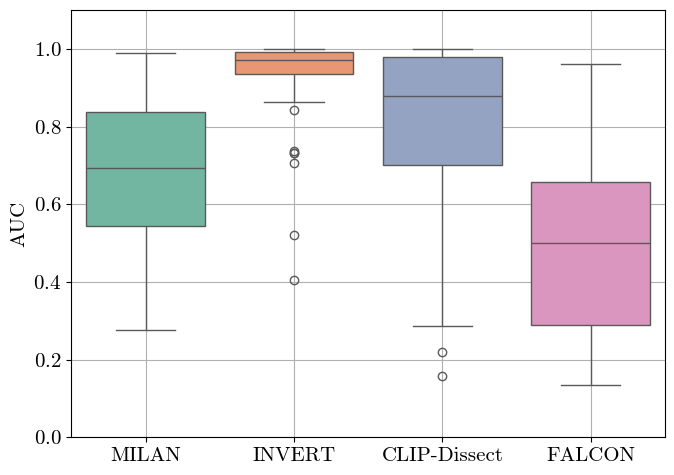

In [13]:
MODEL_NAME = (# "A50k_resnet18-fc"
              # "A50k_resnet18-avgpool" 
              "A50k_resnet18v1-layer4_val"
              # "A50k_vit16b-head"
              # "A50k_vit16b-layer11"
            )
df_falcon = pd.read_csv(PATH+f"evaluation_FALCON_{MODEL_NAME}.csv")
df_milan = pd.read_csv(NAT_SYN_PATH+f"evaluation_MILAN_{MODEL_NAME}.csv")
df_invert = pd.read_csv(PATH+f"evaluation_INVERT_{MODEL_NAME}.csv")
df_clipdis = pd.read_csv(PATH+f"evaluation_CLIP-Dissect_{MODEL_NAME}.csv")

# Combine DataFrames into a single DataFrame with a 'method' column
df_milan['method'] = 'MILAN'
df_invert['method'] = 'INVERT'
df_clipdis['method'] = 'CLIP-Dissect'
df_falcon['method'] = 'FALCON'

combined_df = pd.concat([df_milan, df_invert, df_clipdis,
                         df_falcon
                         ], ignore_index=True)

# Create a vertical boxplot using Seaborn
plt.figure(figsize=(7, 5))
sns.boxplot(x='method', y='auc', hue='method', data=combined_df, palette="Set2", legend=False)

# Set labels and title
plt.ylabel("AUC")
plt.xlabel("")
plt.ylim(0,1.1)

plt.grid(True)

plt.tight_layout()

# Save the plot
# plt.savefig(PLOT_PATH+f"method_auc_comparison_{MODEL_NAME}.png")
# plt.savefig(PLOT_PATH+f"method_auc_comparison_{MODEL_NAME}.pdf")
# plt.savefig(PLOT_PATH+f"method_auc_comparison_{MODEL_NAME}.svg")

# Show the plot
plt.show()

## 2. Compare Natural and Synthetic Images

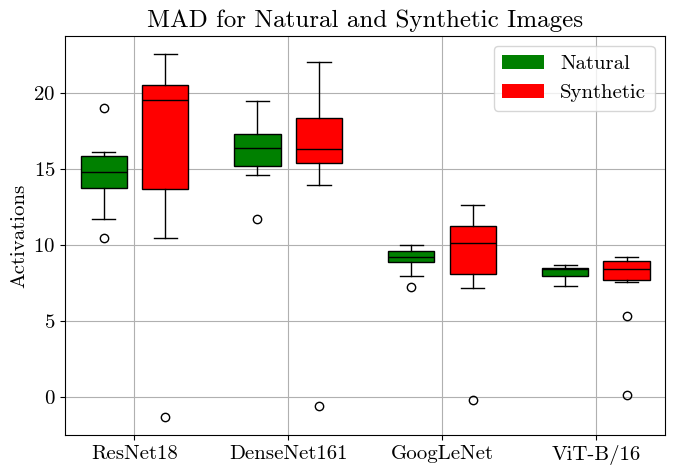

In [24]:
NEURON_IDS = [34, 440, 495, 592, 16, 212, 264, 833, 504, 844]
CONCEPT_NAMES = ['leatherback turtle', 'beer bottle', 'china cabinet', 'hard disc', 'bulbul', 'english setter', 'cardigan', 'submarine', 'coffee mug', 'switch']
CONCEPT_IDS = ['n01665541', 'n02823428', 'n03018349', 'n03492542', 'n01560419', 'n02100735', 'n02113186', 'n04347754', 'n03063599', 'n04372370']
df_imgnt = pd.read_csv("../assets/ILSVRC2012_val_labels.csv")
MODELS = ['resnet18-fc', 'densenet161-fc', 'googlenet-fc', 'vit_b_16-head']
ticks = ['ResNet18', 'DenseNet161', 'GoogLeNet', 'ViT-B/16']

# Initialize lists to collect mean differences for each model
mean_diffs_nat = {model: [] for model in MODELS}
mean_diffs_syn = {model: [] for model in MODELS}

nat_data = [] # [res_nat, dens_nat, goog_nat, vit_nat]
syn_data = [] # [res_syn, dens_syn, goog_syn, vit_syn]

for model in MODELS:
    model_mean_diffs_nat = []
    model_mean_diffs_syn = []
    for neuron_id, concept_id in zip(NEURON_IDS, CONCEPT_IDS):
        # Filter for images including classes
        df_class = df_imgnt[df_imgnt[concept_id] == 1]
        # Filter for images not including classes
        df_non_class = df_imgnt[df_imgnt[concept_id] == 0]

        A_F_val = torch.load(f"../activations/val_{model}.pt").cpu().numpy()
        activ = A_F_val[:, neuron_id]  # All activations for neuron_id on val dataset
        activ_non_class = activ[df_non_class.index]  # Activations without natural class
        activ_class_nat = activ[df_class.index]  # Activations with natural class
        activ_class_syn = torch.load(f"{NAT_SYN_PATH}{model}_neuron-{neuron_id}.pt")[:, neuron_id].cpu().numpy()

        avg_activation_diff_nat = activ_class_nat.mean() - activ_non_class.mean()
        avg_activation_diff_syn = activ_class_syn.mean() - activ_non_class.mean()

        model_mean_diffs_nat.append(avg_activation_diff_nat)
        model_mean_diffs_syn.append(avg_activation_diff_syn)
    
    nat_data.append(model_mean_diffs_nat)
    syn_data.append(model_mean_diffs_syn)

plt.figure(figsize=(7, 5))

colors = ['green', 'red']

bpl = plt.boxplot(nat_data, positions=np.array(range(len(nat_data)))*2.0-0.4, patch_artist=True,boxprops=dict(facecolor=colors[0]), widths=0.6,medianprops=dict(color='black'))
bpr = plt.boxplot(syn_data, positions=np.array(range(len(syn_data)))*2.0+0.4, patch_artist=True,boxprops=dict(facecolor=colors[1]), widths=0.6,medianprops=dict(color='black'))

# Create legend
legend_labels = ['Natural', 'Synthetic']
legend_patches = [plt.Rectangle((0,0),1,1,fc=color) for color in colors]
plt.legend(legend_patches, legend_labels)

plt.xticks(range(0, len(ticks) * 2, 2), ticks)

# plt.xlabel('Models')
plt.ylabel('Activations')
plt.title('MAD for Natural and Synthetic Images')

plt.grid(True)
plt.tight_layout()
# plt.savefig(PLOT_PATH+f"mean_activ_nat-syn_comparison.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"mean_activ_nat-syn_comparison.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"mean_activ_nat-syn_comparison.svg", bbox_inches='tight')
plt.show()

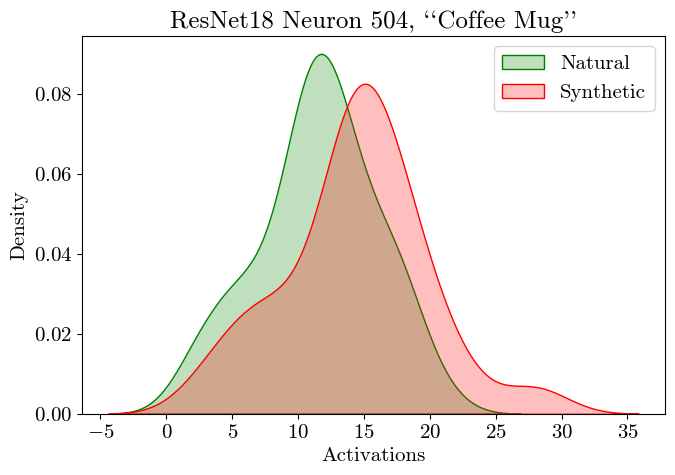

In [17]:
import torch
import seaborn as sns

MODEL_NAME = "resnet18-fc"
NEURON = 504 # coffee mug

res_nat = torch.load(f"{NAT_SYN_PATH}resnet18-fc_natural_neuron-{NEURON}.pt")[:,NEURON].cpu().numpy()
res_syn = torch.load(f"{NAT_SYN_PATH}resnet18-fc_neuron-{NEURON}.pt")[:,NEURON].cpu().numpy()

res_neuron_df = pd.DataFrame({'Natural': res_nat,
                              'Synthetic': res_syn,})

fig, ax = plt.subplots(figsize=(7, 5))

colors = ['green', 'red']

sns.kdeplot(data=res_neuron_df['Natural'], common_norm=True, color=colors[0], fill=True, label='Natural', ax=ax)
sns.kdeplot(data=res_neuron_df['Synthetic'], common_norm=True, color=colors[1], fill=True, label='Synthetic', ax=ax)

plt.xlabel('Activations')
plt.title("ResNet18 Neuron 504, ``Coffee Mug''")

plt.tight_layout()
plt.legend()

# plt.savefig(PLOT_PATH+f"nat-syn_comparison_{MODEL_NAME}_neuron-{NEURON}.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"nat-syn_comparison_{MODEL_NAME}_neuron-{NEURON}.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"nat-syn_comparison_{MODEL_NAME}_neuron-{NEURON}.svg", bbox_inches='tight')
plt.show()

## 3. Psi Comparison ResNet18 Layers

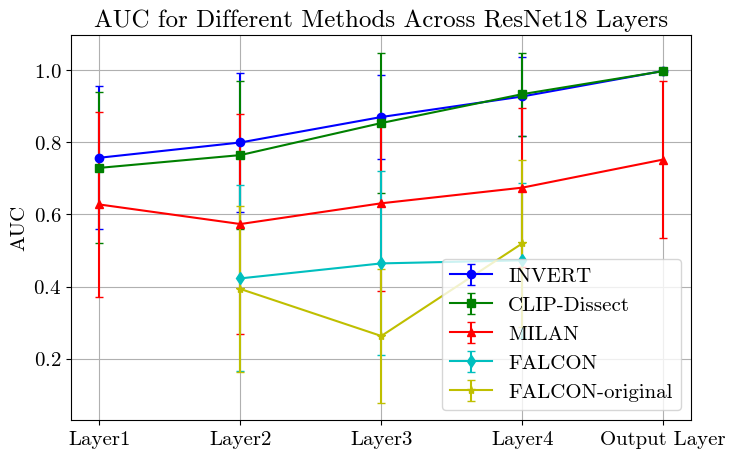

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MODEL_NAMES = ["resnet18-layer1", "resnet18-layer2", "resnet18-layer3", "resnet18-layer4", "resnet18-fc"]
METHODS = ["INVERT", "CLIP-Dissect", "MILAN", "FALCON", "FALCON-original"]
COLORS = ['b', 'g', 'r', 'c', 'y']
MARKERS = ['o', 's', '^', 'd', '*']
x_labels = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Output Layer']
x = np.arange(len(x_labels))

# Initialize dictionaries to hold means and stds for each method
means = {method: [] for method in METHODS}
stds = {method: [] for method in METHODS}


# Load data and calculate means and stds
for MODEL_NAME in MODEL_NAMES:
    for method in METHODS:
        try:
            df = pd.read_csv(f"{PATH}evaluation_{method}_{MODEL_NAME}.csv")
            means[method].append(df['auc'].mean())
            stds[method].append(df['auc'].std())
        except FileNotFoundError:
            # Append NaN if the file does not exist for a particular method and layer
            means[method].append(np.nan)
            stds[method].append(np.nan)

# Create a line plot
plt.figure(figsize=(8, 5))

# Plot error bars for each method
for i, method in enumerate(METHODS):
    plt.errorbar(x, means[method], yerr=stds[method], marker=MARKERS[i], linestyle='-', color=COLORS[i], capsize=3, label=method)

# Customize the plot
# plt.xlabel('Layers')
plt.ylabel('AUC')
plt.title('AUC for Different Methods Across ResNet18 Layers')
plt.xticks(x, x_labels)
plt.legend()
plt.grid(True)
# plt.savefig(PLOT_PATH+f"AUC_resnet18_layers.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"AUC_resnet18_layers.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"AUC_resnet18_layers.svg", bbox_inches='tight')
plt.show()

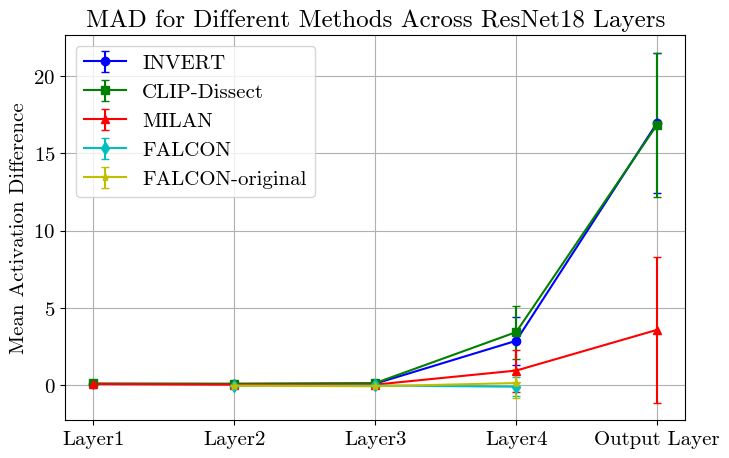

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MODEL_NAMES = ["resnet18-layer1", "resnet18-layer2", "resnet18-layer3", "resnet18-layer4", "resnet18-fc"]
METHODS = ["INVERT", "CLIP-Dissect", "MILAN", "FALCON", "FALCON-original"]
COLORS = ['b', 'g', 'r', 'c', 'y']
MARKERS = ['o', 's', '^', 'd', '*']
x_labels = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Output Layer']
x = np.arange(len(x_labels))

# Initialize dictionaries to hold means and stds for each method
means = {method: [] for method in METHODS}
stds = {method: [] for method in METHODS}

# Load data and calculate means and stds
for MODEL_NAME in MODEL_NAMES:
    for method in METHODS:
        try:
            df = pd.read_csv(f"{PATH}evaluation_{method}_{MODEL_NAME}.csv")
            means[method].append(df['avg. activation diff'].mean())
            stds[method].append(df['avg. activation diff'].std())
        except FileNotFoundError:
            # Append NaN if the file does not exist for a particular method and layer
            means[method].append(np.nan)
            stds[method].append(np.nan)

# Create a line plot
plt.figure(figsize=(8, 5))

# Plot error bars for each method
for i, method in enumerate(METHODS):
    plt.errorbar(x, means[method], yerr=stds[method], marker=MARKERS[i], linestyle='-', color=COLORS[i], capsize=3, label=method)

plt.ylabel('Mean Activation Difference')
plt.title('MAD for Different Methods Across ResNet18 Layers')
plt.xticks(x, x_labels)
plt.legend()
plt.grid(True)
# plt.savefig(PLOT_PATH+f"mean_activ_layers.png", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"mean_activ_layers.pdf", bbox_inches='tight')
# plt.savefig(PLOT_PATH+f"mean_activ_layers.svg", bbox_inches='tight')
plt.show()